# Detrended GPHs

### Domain: 30N-60N and -30E-20E, 1950-2022, JJA
### All timeseries should be weighted by latitude

In [2]:
#load libraries
# load libraries
import pandas as pd
import numpy as np
import netCDF4
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy as ccrs

import scipy.stats as stats
import scipy.interpolate as interpolate
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

In [3]:
import timeit
%alias_magic t timeit 

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [4]:
#load data
era_data = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_gph_1950-2022-0.5_JJA_daily.nc")

In [5]:
#get non detrended data
yearly_gph = era_data.groupby("time.year").mean()
gph_big_europe = yearly_gph.sel(latitude = slice(60,30), longitude = slice(-30,20))
weights = np.cos(np.deg2rad(gph_big_europe.latitude))
weighted_weights = weights/np.mean(weights)

gph_lon = gph_big_europe.mean(dim = "longitude")*weighted_weights
gph = gph_lon.mean(dim = "latitude").z
years = yearly_gph.year
days = era_data.time

In [6]:
#find gph trend
x = np.arange(1,len(years)+1)
cubic_trend = interpolate.splrep(x = years, y = gph, s = len(days))
bspline = interpolate.BSpline(*cubic_trend)
trend1 = (bspline)(years)
cubic_trend

(array([1950., 1950., 1950., 1950., 2022., 2022., 2022., 2022.]),
 array([5766.2225272 , 5772.84861577, 5766.03441324, 5794.0924436 ,
           0.        ,    0.        ,    0.        ,    0.        ]),
 3)

In [7]:
#detrend gph by subtracting non linear trend

#weight daily gphs
weighted_daily = (era_data.sel(latitude = slice(60,30), longitude = slice(-30,20)).mean(dim = "longitude")*weighted_weights).mean(dim = "latitude")

detrended_gph_yearly = (weighted_daily.groupby('time.year') - (gph/gph)*trend1).drop_vars('year').z
detrended_gph_yearly

<xarray.DataArray 'z' (time: 26390)>
array([-32.66344517, -27.41686313, -22.90123813, ...,  17.11898218,
        39.01351343,  37.15120874])
Coordinates:
  * time     (time) datetime64[ns] 1950-06-01 1950-06-02 ... 2022-08-31

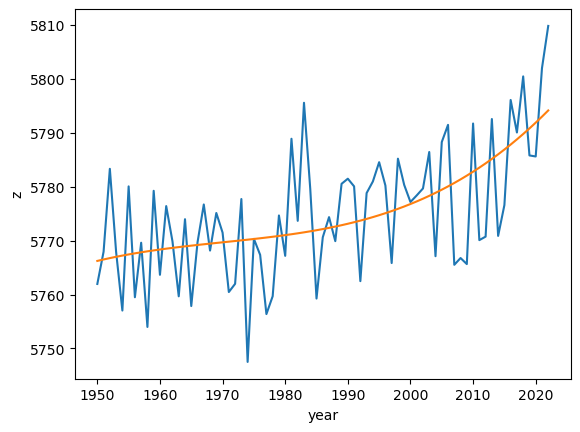

In [8]:
gph.plot()
plt.plot(years, trend1)

In [9]:
#find monthly spatial averages
monthly_gph = era_data.resample(time = "1M", skipna = True).mean()
weighted_monthly = (monthly_gph.sel(latitude = slice(60,30), 
                                longitude = slice(-30,20)).mean(dim = "longitude")*weighted_weights).mean(dim = "latitude")
weighted_monthly_nan = []
#get rid of the nans
for x in weighted_monthly.z.values:
    if x > 0:
        weighted_monthly_nan.append(x)
        
#get trend
months = monthly_gph.time
x2 = np.arange(1,len(weighted_monthly_nan)+1)
cubic_trend2 = interpolate.splrep(x = x2, y = weighted_monthly_nan, s = 10e5)
bspline2 = interpolate.BSpline(*cubic_trend2)
trend2 = (bspline2)(x2)

In [10]:
#detrend by monthly spatial average
years = np.arange(1950, 2023)
months = np.array(("-06", "-07", "-08"))
index = 0

#set up detrended array
detrended_gph = era_data.sel(time = "1950-06") - trend2[0]

for year in years:
    for month in months:
        time = str(year)+month #define the year and month period
        if time == "1950-06":
            continue
        else:
            gph = era_data.sel(time = time) #get gph for that day
            new_gph = gph - trend2[index+1]
            detrended_gph = xr.concat([detrended_gph, new_gph], dim = 'time') #add new detrended gph to array
            index = index + 1

## Analogues of June 19th 2019

In [11]:
#make map of the gph over the area

#import temperature data
era_max = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_t2m_1950-2022_daily_max_regrid.nc")
era_mean = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_t2m_1950-2022_daily_mean.nc")
ref_temp = era_max.sel(time = '2019-06-19')
ref_gph = detrended_gph.sel(time = '2019-06-29')

In [12]:
era_max.sel(time = '2011-01-01')

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 91)
Coordinates:
  * longitude  (longitude) float32 -30.0 -29.5 -29.0 -28.5 ... 39.0 39.5 40.0
  * latitude   (latitude) float32 75.0 74.5 74.0 73.5 ... 31.5 31.0 30.5 30.0
    time       datetime64[ns] 2011-01-01
Data variables:
    t2m        (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-12 19:36:05 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [13]:
#find climatologies
gph_clim = detrended_gph.groupby('time.dayofyear').mean(dim='time', skipna = True).sel(dayofyear = slice(152,244))
temp_clim = era_mean.groupby('time.dayofyear').mean(dim='time', skipna = True).sel(dayofyear = slice(152,244))

In [14]:
#find climatology for june 29th
ref_temp_clim = temp_clim.sel(dayofyear = 180)
ref_gph_clim = gph_clim.sel(dayofyear = 180)

#find anomalies
ref_temp_anom = (ref_temp - ref_temp_clim).t2m
ref_gph_anom = (ref_gph - ref_gph_clim).z

Text(0.5, 1.0, 'Geopotential Height Anomaly for June 29th 2019')

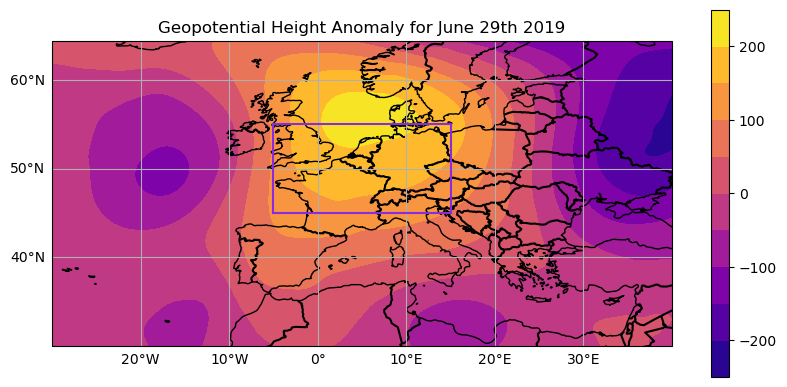

In [15]:
transform = ccrs.Orthographic(central_longitude = 5, central_latitude = 50)
fig = plt.figure(figsize = (10,15))
latgrids=[40,50,60]
longrids=[-20,-10,0,10,20,30]

ax = plt.subplot(2,1,1,projection = ccrs.PlateCarree())
j = plt.contourf(ref_gph_anom.longitude, ref_gph_anom.latitude, ref_gph_anom.values,
                                    cmap = 'plasma', levels = np.linspace(-250,250,11), 
                                 transform = ccrs.PlateCarree())
plt.colorbar(j, shrink = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.set_extent([-30, 40, 30, 60])
#plotting box
bv = "blueviolet"
plt.plot([-5,-5], [45,55], color = bv)
plt.plot([15,15], [45,55], color = bv)
plt.plot([-5,15], [45,45], color = bv)
plt.plot([-5,15], [55,55], color = bv)
gl = ax.gridlines(draw_labels=True, x_inline=None, y_inline=False)
gl.ylocator = matplotlib.ticker.FixedLocator(latgrids)
gl.xlocator = matplotlib.ticker.FixedLocator(longrids)
gl.top_labels = None
gl.right_labels = None
ax.set_title("Geopotential Height Anomaly for June 29th 2019")

Text(0.5, 1.0, 'Temperature Anomaly for June 29th 2019')

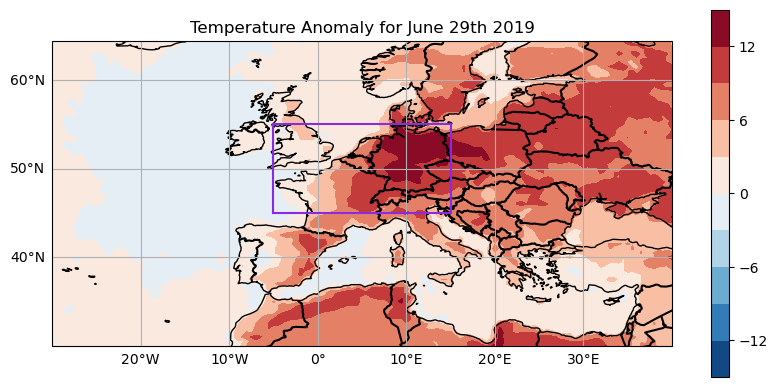

In [16]:
transform = ccrs.Orthographic(central_longitude = 5, central_latitude = 50)
fig = plt.figure(figsize = (10,15))
latgrids=[40,50,60]
longrids=[-20,-10,0,10,20,30]

ax = plt.subplot(2,1,1,projection = ccrs.PlateCarree())
j = plt.contourf(ref_temp_anom.longitude, ref_temp_anom.latitude, ref_temp_anom.values,
                                    cmap = 'RdBu_r', levels = np.linspace(-15,15,11), 
                                 transform = ccrs.PlateCarree())
plt.colorbar(j, shrink = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.set_extent([-30, 40, 30, 60])
#plotting box
bv = "blueviolet"
plt.plot([-5,-5], [45,55], color = bv)
plt.plot([15,15], [45,55], color = bv)
plt.plot([-5,15], [45,45], color = bv)
plt.plot([-5,15], [55,55], color = bv)
gl = ax.gridlines(draw_labels=True, x_inline=None, y_inline=False)
gl.ylocator = matplotlib.ticker.FixedLocator(latgrids)
gl.xlocator = matplotlib.ticker.FixedLocator(longrids)
gl.top_labels = None
gl.right_labels = None
ax.set_title("Temperature Anomaly for June 29th 2019")

In [17]:
#find anomalies for each day
detrended_anomalies = detrended_gph.groupby('time.dayofyear') - gph_clim

In [18]:
analogue_hopefuls = (detrended_anomalies - ref_gph_anom.values)**2

In [19]:
#find mean over lat and lon
distances = analogue_hopefuls.mean(dim = ['latitude', 'longitude'])
distances_arranged = np.sort(distances.z.values)
analogues_3 = distances_arranged[0:4]

analogue_day1 = np.where(distances.z == analogues_3[1])
analogue_day2 = np.where(distances.z == analogues_3[2])
analogue_day3 = np.where(distances.z == analogues_3[3])

date_1 = distances.time[analogue_day1]
date_2 = distances.time[analogue_day2]
date_3 = distances.time[analogue_day3]

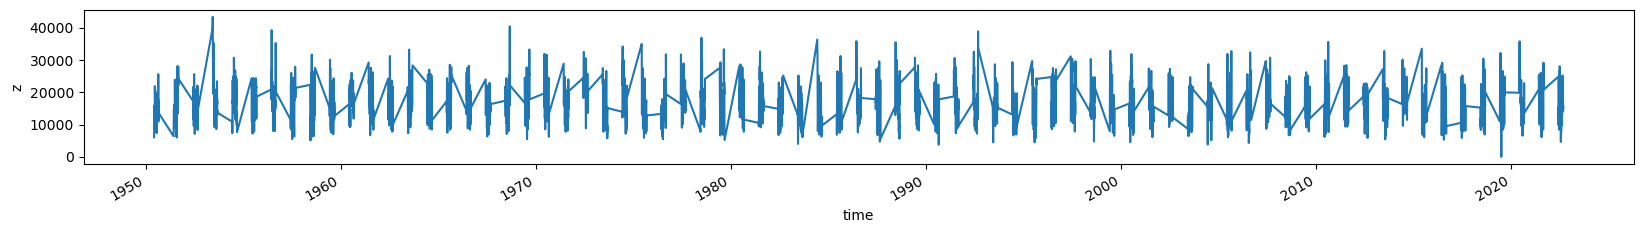

In [20]:
plt.figure(figsize = (20,2))
analogue_hopefuls.mean(dim = ['latitude', 'longitude']).z.plot()

/scratch/rwhite/jrobs12/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/scratch/rwhite/jrobs12/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/scratch/rwhite/jrobs12/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/scratch/rwhite/jrobs12/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


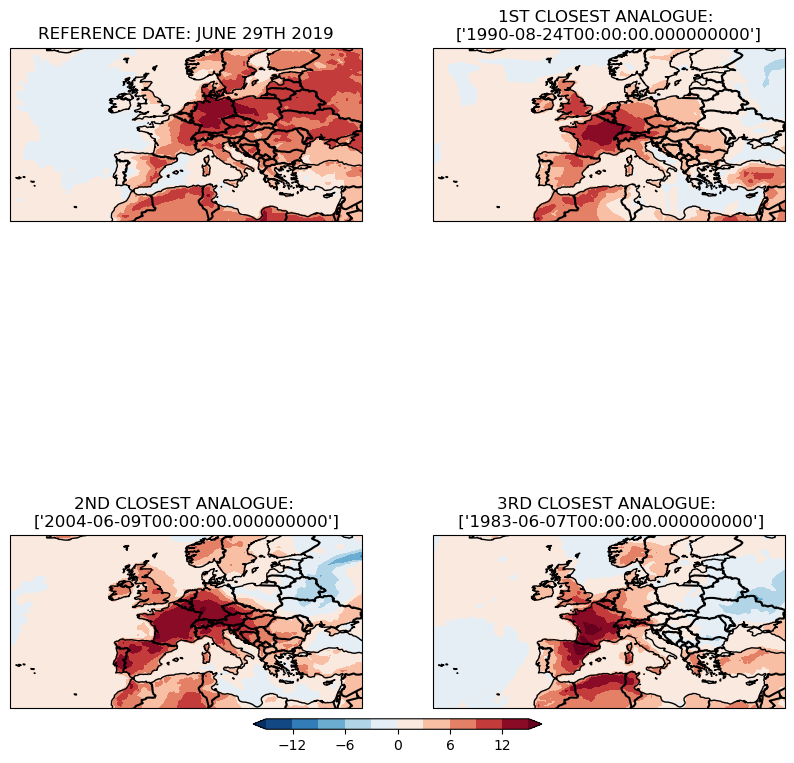

In [21]:
import matplotlib.gridspec as gridspec
#plotting temperature anomalies at these dates
gridspec.GridSpec(60,45)
#plot 1 (refrence day)
fig = plt.figure(figsize = (10,10))
latgrids=[40,50,60]
longrids=[-20,-10,0,10,20,30]


ax1 = plt.subplot(2,2,1,projection = ccrs.PlateCarree())
j = plt.contourf(ref_temp_anom.longitude, ref_temp_anom.latitude, ref_temp_anom.values,
                                    cmap = 'RdBu_r', levels = np.linspace(-15,15,11), 
                                 transform = ccrs.PlateCarree(), extend = 'max', add_colorbar = False)
#plt.colorbar(j, shrink = 0.7)
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=1.5)
ax1.set_extent([-30, 40, 30, 60])
ax1.set_title("REFERENCE DATE: JUNE 29TH 2019")

#plot 2: next closest analogue
analogue1 = (era_max.sel(time = date_1.time) - temp_clim.sel(dayofyear = date_1.dayofyear)).mean(dim = 'time').t2m
ax2 = plt.subplot(2,2,2,projection = ccrs.PlateCarree())
h = plt.contourf(analogue1.longitude, analogue1.latitude, analogue1.values,
                                    cmap = 'RdBu_r', levels = np.linspace(-15,15,11), 
                                 transform = ccrs.PlateCarree(), extend = 'max', add_colorbar = False)
#plt.colorbar(j, shrink = 0.7)
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=1.5)
ax2.set_extent([-30, 40, 30, 60])
ax2.set_title(f"1ST CLOSEST ANALOGUE: \n{date_1.time.values}")


#plot 3: 2nd closest analogue
analogue2 = (era_max.sel(time = date_2.time) - temp_clim.sel(dayofyear = date_2.dayofyear)).mean(dim = 'time').t2m
ax3 = plt.subplot(2,2,3,projection = ccrs.PlateCarree())
i = plt.contourf(analogue2.longitude, analogue2.latitude, analogue2.values,
                                    cmap = 'RdBu_r', levels = np.linspace(-15,15,11), 
                                 transform = ccrs.PlateCarree(), extend = 'max', add_colorbar = False)
#plt.colorbar(j, shrink = 0.7)
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS, linewidth=1.5)
ax3.set_extent([-30, 40, 30, 60])
ax3.set_title(f"2ND CLOSEST ANALOGUE: \n{date_2.time.values}")


#plot 3: FINAL closest analogue
analogue3 = (era_max.sel(time = date_3.time) - temp_clim.sel(dayofyear = date_3.dayofyear)).mean(dim = 'time').t2m
ax4 = plt.subplot(2,2,4,projection = ccrs.PlateCarree())
j = plt.contourf(analogue3.longitude, analogue3.latitude, analogue3.values,
                                    cmap = 'RdBu_r', levels = np.linspace(-15,15,11), 
                                 transform = ccrs.PlateCarree(), extend = 'both', add_colorbar = False)
#plt.colorbar(j, shrink = 0.7)
ax4.coastlines()
ax4.add_feature(cfeature.BORDERS, linewidth=1.5)
ax4.set_extent([-30, 40, 30, 60])
ax4.set_title(f"3RD CLOSEST ANALOGUE: \n {date_3.time.values}")

#plt.suptitle("FIRST TRY OF ANALOGUES: MANUAL", fontsize = 30)
plt.colorbar(j,fraction = 0.03,shrink = 0.7, pad = 0.03, aspect = 25,  ax=[ax3, ax4], orientation = 'horizontal')
plt.savefig('first_try_analogues.png')

In [22]:
detrended_anomalies.sel(time = slice("1950", "1960")).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 81, time: 1012)
Coordinates:
  * longitude  (longitude) float32 -30.0 -29.5 -29.0 -28.5 ... 39.0 39.5 40.0
  * latitude   (latitude) float32 70.0 69.5 69.0 68.5 ... 31.5 31.0 30.5 30.0
  * time       (time) datetime64[ns] 1950-06-01 1950-06-02 ... 1960-08-31
    dayofyear  (time) int64 152 153 154 155 156 157 ... 239 240 241 242 243 244
Data variables:
    z          (time, latitude, longitude) float32 -96.82 -94.04 ... -10.11>

In [34]:
test_days = detrended_anomalies.time.values
loop_number = 1
for day in test_days:
    ### Find analogue temp field for first day
    ds_max = detrended_anomalies

    # select day
    ind_sel = 0
    date_sel = day #ds_max.time[ind_sel].values
    # get year of day selected as str
    year_sel = ds_max.time[ind_sel].dt.year.values.astype('str').item()

    ## select data from this day
    ds_max_date = ds_max.sel(time = date_sel)

    ## select rest of data, minus all dates in year selected
    # Note: assuming there is only JJA in dataset
    year_sel_all = np.arange(year_sel+'-06-01', year_sel+'-09-01', np.timedelta64(1,'D'), dtype='datetime64[ns]')
    ds_max_else = ds_max.drop_sel(time = year_sel_all)

    ## calculate euclid. dist. w/ all other days
    ds_max_diff = ds_max_else - ds_max_date  # take difference
    ds_max_diff_sq = ds_max_diff**2   # square difference
    ds_max_diff_sq_sum = ds_max_diff_sq.sum(dim=['latitude','longitude'])  # sum
    ds_max_rmse = ds_max_diff_sq_sum**(1/2)   # square root

    ## find 3 lowest rmse / euclid. dist. (separated by at least 14 days)
    # sort min to max rmse
    # Note: here 'tp' would be whatever Z500 stored as
    ds_max_rmse_sort = ds_max_rmse.sortby("z").z

    # take time difference between each adjacent point in sorted data
    time_diffs = ds_max_rmse_sort.time.values.astype('datetime64[D]') - ds_max_date.time.values.astype('datetime64[D]')
    #time_diffs = np.diff(ds_max_rmse_sort.time.values.astype('datetime64[D]'))
    # find indices where time difference is > 14 days
    time_diffs_inds_sel = np.where(np.abs(time_diffs) > np.timedelta64(14,'D'))[0]

    #miminum RMSE is always the actual date itself
    anlg_date0 = ds_max_rmse_sort.time.values[0]

    # then next is where first time_diff > 14d
    index = 0
    anlg_date1 = ds_max_rmse_sort.time.values[time_diffs_inds_sel[index]]
    anlg_date2 = ds_max_rmse_sort.time.values[time_diffs_inds_sel[index+1]]

    index = 2
    anlg_diff12 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]'))

    #check that dates 1 and 2 are at least 14 days apart
    if anlg_diff12 < np.timedelta64(14, 'D'):
        index = index + 1
        anlg_date2 = ds_max_rmse_sort.time.values[time_diffs_inds_sel[index]]
        new_diff12 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]'))
        #find new analogue
        if new_diff12 < np.timedelta64(14, 'D'):
            while new_diff12 < np.timedelta64(14, 'D'):
                index = index + 1
                anlg_date2 = ds_max_rmse_sort.time.values[time_diffs_inds_sel[index]]
                new_diff12 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]'))

    anlg_date3 = ds_max_rmse_sort.time.values[time_diffs_inds_sel[index]]
    anlg_diff13 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
    anlg_diff23 = np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))

    #make sure that the 3rd analogue day is also at least 14 days from the others
    if anlg_diff13 < np.timedelta64(14, 'D') or anlg_diff23 < np.timedelta64(14, 'D'):
        index = index + 1
        anlg_date3 = ds_max_rmse_sort.time.values[time_diffs_inds_sel[index]]
        new_diff13 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
        new_diff23 = np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
        if new_diff13 < np.timedelta64(14, 'D') or new_diff23 < np.timedelta64(14, 'D'):
        #find new lowest analogue
            while new_diff13 < np.timedelta64(14, 'D') or new_diff23 < np.timedelta64(14, 'D'):
                index+=1
                anlg_date3 = ds_max_rmse_sort.time.values[time_diffs_inds_sel[index]]
                new_diff13 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
                new_diff23 = np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
    # check dates
    if np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]')) < np.timedelta64(14,'D'):
        print("Error: analogues selected within 14 days of each other")
    elif np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]')) < np.timedelta64(14,'D'):
        print("Error: analogues selected within 14 days of each other")
    elif np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]')) < np.timedelta64(14,'D'):
        print("Error: analogues selected within 14 days of each other")
    # print(anlg_date1)
    # print(anlg_date2)
    # print(anlg_date3)

    # concat data from these three dates together
    # Note: these should be temp arrays of analogue dates together (not ds_max again)
    anlg_all = xr.concat([ds_max.sel(time = anlg_date1), ds_max.sel(time=anlg_date2), ds_max.sel(time=anlg_date3)], dim='N')
    anlg_temps = era_max.sel(time = anlg_all.time)
    anlg_temps1 = era_max.sel(time = anlg_date1).assign_coords(time=date_sel)
    anlg_temps2 = era_max.sel(time = anlg_date2).assign_coords(time=date_sel)
    anlg_temps3 = era_max.sel(time = anlg_date3).assign_coords(time=date_sel)
    # take mean over new dimension, N
    anlg_temps_avg = anlg_temps.mean(dim='N').assign_coords(time=date_sel)
    # if this is the first time point, create new analogue temp field
    #   that will be continually added to
    if loop_number == 1:
        anlg_mix = anlg_temps_avg
        anlg_mix1 = anlg_temps1
        anlg_mix2 = anlg_temps2
        anlg_mix3 = anlg_temps3
    
    else:
    # if this is not first time point,
    #    add to new analogues to ongoing temp field dataArray
        anlg_mix = xr.concat([anlg_mix, anlg_temps_avg], dim='time')
        anlg_mix1 = xr.concat([anlg_mix1, anlg_temps1], dim='time')
        anlg_mix2 = xr.concat([anlg_mix2, anlg_temps2], dim='time')
        anlg_mix3 = xr.concat([anlg_mix3, anlg_temps3], dim='time')
    loop_number += 1
    if loop_number % 500 == 0:
        print(loop_number)
    #print(anlg_date0)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


In [89]:
ds_max_rmse_sort.time.values[0:10]

array(['2022-08-31T00:00:00.000000000', '2022-08-30T00:00:00.000000000',
       '2021-08-22T00:00:00.000000000', '1968-07-26T00:00:00.000000000',
       '1971-08-22T00:00:00.000000000', '1957-08-04T00:00:00.000000000',
       '1975-06-28T00:00:00.000000000', '1968-07-29T00:00:00.000000000',
       '1957-08-05T00:00:00.000000000', '1952-07-24T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [88]:
anlg_all.time.values

array(['2021-08-22T00:00:00.000000000', '1968-07-26T00:00:00.000000000',
       '1971-08-22T00:00:00.000000000'], dtype='datetime64[ns]')

In [39]:
#import data for trends
#monthly global mean temperatures
global_months = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_monthly_temperature_1940-2024_global.nc")
#land sea mask
lsm = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/europe_mask_0.5.nc")
small_mask = (lsm.sel(longitude = slice(-5,15), latitude = slice(55,45)).t2m)/(lsm.sel(longitude = slice(-5,15), 
                                                                                       latitude = slice(55,45)).t2m)
#find gwd
#weighting by latitude
weights = np.cos(np.deg2rad(global_months.latitude))
weighted_weights = weights/np.mean(weights)

weighted_temps = global_months.sel(expver = 1).groupby("latitude")*weighted_weights
weighted_global_mean = weighted_temps.t2m.sel(time = slice('1950', '2022')).mean(dim = ['latitude', 'longitude'])
weighted_yearly_mean = weighted_global_mean.groupby("time.year").mean()
weighted_rolling_mean = weighted_yearly_mean.rolling(year = 5, center=True, min_periods = 3).mean()
weighted_gwd_2022 = weighted_rolling_mean[-1]
weighted_gwd = weighted_rolling_mean - weighted_gwd_2022
#weighted_gwd

<xarray.DataArray 't2m' (year: 73)>
array([-1.0198059 , -0.99212646, -1.0148926 , -1.019104  , -1.061676  ,
       -1.0514526 , -1.0432739 , -1.0027466 , -0.9676819 , -0.9055786 ,
       -0.9052429 , -0.91085815, -0.95184326, -0.971405  , -0.9904785 ,
       -0.9948425 , -1.0190125 , -0.97457886, -0.9476013 , -0.9671936 ,
       -0.9623718 , -0.92440796, -0.967865  , -1.0013123 , -1.0174866 ,
       -1.0035706 , -1.0221252 , -0.95440674, -0.86538696, -0.7559509 ,
       -0.7435913 , -0.68045044, -0.69091797, -0.7357483 , -0.76950073,
       -0.7322693 , -0.7276306 , -0.70410156, -0.6262207 , -0.5770569 ,
       -0.6053772 , -0.6309509 , -0.62561035, -0.63098145, -0.6514282 ,
       -0.60098267, -0.5220032 , -0.50405884, -0.52267456, -0.48324585,
       -0.4489746 , -0.4550171 , -0.41952515, -0.35061646, -0.32333374,
       -0.3168335 , -0.33422852, -0.31323242, -0.3055725 , -0.3166504 ,
       -0.31600952, -0.28344727, -0.26919556, -0.24420166, -0.15411377,
       -0.09335327, -0.05395508,  0.00463867,  0.03994751,  0.00683594,
       -0.00170898,  0.01583862,  0.        ], dtype=float32)
Coordinates:
    expver   int32 1
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021 2022

In [84]:
#select western europe region, find yearly maximum and weight by latitude
#first analogue set
anlg_TXx1 = anlg_mix1.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max()*small_mask
anlg_TXx1_w = anlg_TXx1.mean(dim = 'longitude').groupby('latitude')*weighted_weights
anlg_TXx1_weighted = anlg_TXx1_w.mean(dim = 'latitude').t2m

#second analogue set
anlg_TXx2 = anlg_mix2.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max()*small_mask
anlg_TXx2_w = anlg_TXx2.mean(dim = 'longitude').groupby('latitude')*weighted_weights
anlg_TXx2_weighted = anlg_TXx2_w.mean(dim = 'latitude').t2m

#third analogue set
anlg_TXx3 = anlg_mix3.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max()*small_mask
anlg_TXx3_w = anlg_TXx3.mean(dim = 'longitude').groupby('latitude')*weighted_weights
anlg_TXx3_weighted = anlg_TXx3_w.mean(dim = 'latitude').t2m

#analogue series where the temperatures are averaged in the loop
anlg_TXx4 = anlg_mix.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max()*small_mask
anlg_TXx4_w = anlg_TXx4.mean(dim = 'longitude').groupby('latitude')*weighted_weights
anlg_TXx4_weighted = anlg_TXx4_w.mean(dim = 'latitude').t2m

#take average of all three sets of analogues for each year
anlg_TXx = (anlg_TXx1_weighted + anlg_TXx2_weighted + anlg_TXx3_weighted)/3

In [93]:
anlg_TXx3

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 21, year: 73, time: 1)
Coordinates:
  * longitude  (longitude) float32 -5.0 -4.5 -4.0 -3.5 ... 13.5 14.0 14.5 15.0
  * latitude   (latitude) float32 55.0 54.5 54.0 53.5 ... 46.5 46.0 45.5 45.0
  * year       (year) int64 1950 1951 1952 1953 1954 ... 2019 2020 2021 2022
  * time       (time) datetime64[ns] 2022-06-02
Data variables:
    t2m        (year, latitude, longitude, time) float32 292.4 296.3 ... 305.7

In [95]:
#calculate linear regression with GWD
anlg_trend = stats.linregress(weighted_gwd, anlg_TXx.T)
anlg_trend4 = stats.linregress(weighted_gwd, anlg_TXx4_weighted.T)
anlg_trend

LinregressResult(slope=0.3854250282891599, intercept=307.5904628152098, rvalue=0.1750125926757208, pvalue=0.1386183552576708, stderr=0.25732759450758713, intercept_stderr=0.1867734295706199)

In [74]:
#anlg_mix.to_netcdf("/scratch/rwhite/jrobs12/analogue_data/era_analogues1.nc")

In [76]:
anlg_mix1

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 91, time: 6716)
Coordinates:
  * longitude  (longitude) float32 -30.0 -29.5 -29.0 -28.5 ... 39.0 39.5 40.0
  * latitude   (latitude) float32 75.0 74.5 74.0 73.5 ... 31.5 31.0 30.5 30.0
  * time       (time) datetime64[ns] 1950-06-01 1950-06-02 ... 2022-08-31
Data variables:
    t2m        (time, latitude, longitude) float32 259.4 259.8 ... 316.2 317.1
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-12 19:36:05 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [102]:
TXx = np.array([303.06125, 300.8648 , 304.40012, 302.06064, 300.56473, 301.5503 ,
        299.78998, 304.5593 , 300.64487, 303.63666, 300.87308, 302.48593,
        300.98578, 301.78052, 303.40918, 300.07336, 301.72928, 301.9841 ,
        302.46927, 302.75467, 301.6033 , 302.6268 , 301.36646, 302.45834,
        302.48315, 303.66544, 304.32443, 300.3028 , 300.61432, 300.7099 ,
        301.66064, 301.43814, 302.67642, 305.38687, 303.5553 , 302.1996 ,
        303.44507, 301.92047, 301.29086, 303.37216, 304.72327, 303.20007,
        304.29623, 301.23703, 304.59558, 304.7117 , 302.73224, 302.547  ,
        304.4615 , 303.25143, 303.80075, 303.72845, 303.76572, 306.8902 ,
        302.5182 , 303.92194, 305.74976, 303.55066, 302.54483, 304.1514 ,
        304.21677, 303.96576, 305.01968, 305.28152, 303.6588 , 306.4019 ,
        304.83112, 304.23816, 305.54166, 308.1024 , 305.8689 , 303.66074,
        305.53278])

In [107]:
time

<xarray.DataArray 'year' (year: 73)>
array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022])
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021 2022

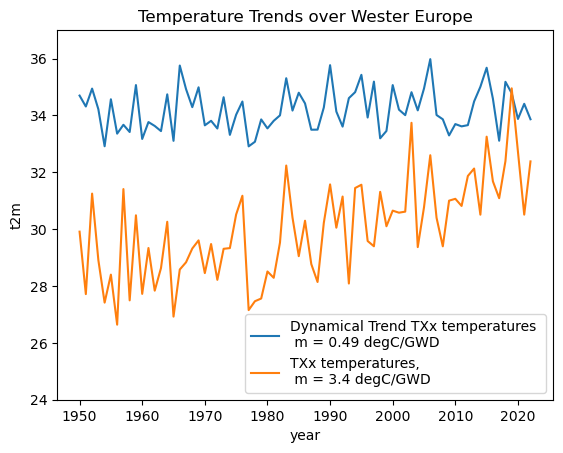

In [111]:
(anlg_TXx - 273.15).plot(label = "Dynamical Trend TXx temperatures \n m = 0.49 degC/GWD")
time = anlg_TXx.year
plt.plot(time.values,TXx - 273.15, label = "TXx temperatures, \n m = 3.4 degC/GWD")
plt.ylim(24,37)
plt.title("Temperature Trends over Wester Europe")
plt.legend()

In [112]:
#(anlg_TXx - 273.15).to_netcdf('/scratch/rwhite/jrobs12/analogue_data/first_try_analogues.nc')